In [2]:
import os
import pandas as pd

def aggregate_pred_dataframe(files):
    dfs = [pd.read_csv(f) for f in files]
    final_df = dfs[0].rename(columns={'pred': 'pred_0'})
    for i in range(1, len(dfs)):
        final_df[f'pred_{i}'] = dfs[i]['pred']
    return final_df.reset_index()

def get_preds_with_prefixes(prefixes, seed_start=0, seed_end=20):
    if prefixes is str:
        prefixes = [prefixes]
    csv_files = [file for file in os.listdir('preds') if file.endswith('.csv')]
    csv_files.sort()
    len(csv_files)
    preds = []
    for seed in range(seed_start, seed_end):
        for prefix in prefixes:
            filtered = [file for file in csv_files if file.startswith(f'{prefix}_{seed}_')] # get all file with same seed
            valid_filtered = [file for file in filtered if file.endswith('valid.csv')] # get all valid file
            test_filtered = [file for file in filtered if file.endswith('test.csv')] # get all test file
            if filtered:
                preds.append((valid_filtered[-1], test_filtered[-1]))
    return preds

def aggregate_preds(preds):
    df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in preds])
    df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in preds])
    
    return df_valid, df_test

%matplotlib inline
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np

def round_dict(d, n):
    return {k: round(v, n) if isinstance(v, float) else v
                for k, v in d.items()}

def generate_mean_ensemble_metrics(df, threshold=0):
    sum_preds = df[list(filter(lambda a: a.startswith('pred_'), df.columns.tolist()))].mean(axis=1)
    final_prediction = (sum_preds > threshold).astype(int)

    # Sensitivity (Recall)
    sensitivity = recall_score(df['target'], final_prediction)

    # Specificity
    tn, fp, fn, tp = confusion_matrix(df['target'], final_prediction).ravel()
    specificity = tn / (tn + fp)

    # Accuracy
    accuracy = accuracy_score(df['target'], final_prediction)

    # Precision
    precision = precision_score(df['target'], final_prediction)
    mcc = matthews_corrcoef(df['target'], final_prediction)
    return {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "accuracy": accuracy,
        "precision": precision,
        "mcc": mcc,
    }
    
def draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-3, end=1, step=0.1,
                                      plot=True):
    # Create a list of thresholds to test
    thresholds = np.arange(start, end, step)  # Adjust the step size as necessary
    valid_mccs = []
    test_metrics = []

    # Loop through thresholds and compute MCC
    for threshold in thresholds:
        metrics = generate_mean_ensemble_metrics(df_valid, threshold)
        valid_mccs.append(metrics['mcc'])
        
        metrics_test = generate_mean_ensemble_metrics(df_test, threshold)
        test_metrics.append(metrics_test)

    # Identify threshold with the best MCC
    best_threshold_arg = np.argmax(valid_mccs)
    best_threshold = thresholds[best_threshold_arg]

    label = f'Best Threshold: {best_threshold:.1f}, Valid MCC: {valid_mccs[best_threshold_arg]:.3f}, Test MCC: {test_metrics[best_threshold_arg]["mcc"]:.3f}'
    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, valid_mccs, label='Valid MCC', color='blue')
        plt.plot(thresholds, [i['mcc'] for i in test_metrics], label='Test MCC', color='green')
        plt.axvline(x=best_threshold, color='red', linestyle='--', label=label)
        plt.xlabel('Threshold')
        plt.ylabel('MCC Value')
        plt.title('MCC vs. Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
    return {
        'best_threshold': best_threshold, 
        'valid_mcc': valid_mccs[best_threshold_arg],
        **test_metrics[best_threshold_arg]
    }


def random_small_ensembles(preds, n, trial, start=-3, end=1, step=0.1):
    from random import sample
    df = pd.DataFrame()
    for i in range(trial):
        sample_preds = sample(preds, n)
        df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in sample_preds])
        df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in sample_preds])


        new_row = [draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=start, end=end, step=step, plot=False)]
        new_df = pd.DataFrame(new_row)
        df = pd.concat([df, new_df], ignore_index=True)

    return df


def summarize_prefix(prefixes, n, plot=False, start=-3, end=1, step=0.1, apply_sig=False, seed_start=0, seed_end=20):
    preds = get_preds_with_prefixes(prefixes, seed_start=seed_start, seed_end=seed_end)
    print(preds)
    df_valid, df_test = aggregate_preds(preds)
    print(f'Ensemble of all {len(preds)} models:')
    
    if apply_sig:
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        # Apply the sigmoid function to all pred columns
        pred_columns = df_valid.filter(like='pred_').columns
        df_valid[pred_columns] = df_valid[pred_columns].apply(sigmoid)
        df_test[pred_columns] = df_test[pred_columns].apply(sigmoid)
    print(round_dict(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=start, end=end, step=step, plot=plot), 4))

    print(f'Ensemble of {n} random models:')
    df = random_small_ensembles(preds, n, 10, start=start, end=end, step=step)
    return df.aggregate(['mean', 'std', 'max']).T.round(3)


[('v014_0_0.6882_valid.csv', 'v014_0_0.6882_test.csv'), ('v014_1_0.6715_valid.csv', 'v014_1_0.6715_test.csv'), ('v014_2_0.6662_valid.csv', 'v014_2_0.6662_test.csv'), ('v014_3_0.6886_valid.csv', 'v014_3_0.6886_test.csv'), ('v014_4_0.6696_valid.csv', 'v014_4_0.6696_test.csv'), ('v014_5_0.6804_valid.csv', 'v014_5_0.6804_test.csv'), ('v014_6_0.6585_valid.csv', 'v014_6_0.6585_test.csv'), ('v014_7_0.6773_valid.csv', 'v014_7_0.6773_test.csv'), ('v014_8_0.6773_valid.csv', 'v014_8_0.6773_test.csv'), ('v014_9_0.6746_valid.csv', 'v014_9_0.6746_test.csv'), ('v014_10_0.6846_valid.csv', 'v014_10_0.6846_test.csv'), ('v014_11_0.6802_valid.csv', 'v014_11_0.6802_test.csv'), ('v014_12_0.6732_valid.csv', 'v014_12_0.6732_test.csv'), ('v014_13_0.6593_valid.csv', 'v014_13_0.6593_test.csv'), ('v014_14_0.6772_valid.csv', 'v014_14_0.6772_test.csv'), ('v014_15_0.6732_valid.csv', 'v014_15_0.6732_test.csv'), ('v014_16_0.6690_valid.csv', 'v014_16_0.6690_test.csv'), ('v014_17_0.6769_valid.csv', 'v014_17_0.6769_test.

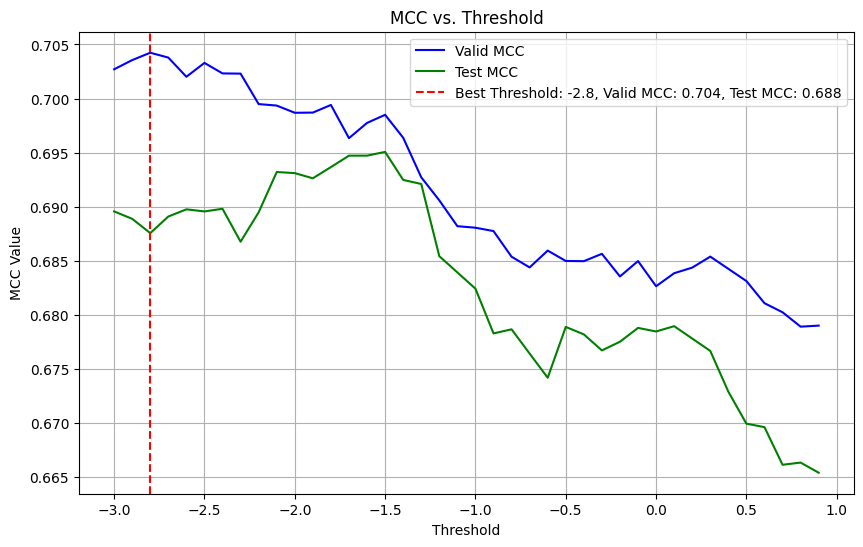

{'best_threshold': -2.8, 'valid_mcc': 0.7042, 'sensitivity': 0.6762, 'specificity': 0.9864, 'accuracy': 0.9703, 'precision': 0.731, 'mcc': 0.6876}
Ensemble of 20 random models:


,mean,std,max
best_threshold,-2.710,0.390,-2.000
valid_mcc,0.704,0.002,0.707
sensitivity,0.677,0.010,0.692
specificity,0.986,0.001,0.988
accuracy,0.970,0.001,0.971
precision,0.732,0.013,0.753
mcc,0.688,0.004,0.694


In [21]:
summarize_prefix(['v014'], n=20, plot=True, start=-3, end=1, step=0.1, seed_start=0, seed_end=40)

[('v025_20_0.6212_valid.csv', 'v025_20_0.6212_test.csv'), ('v025_21_0.6291_valid.csv', 'v025_21_0.6291_test.csv'), ('v025_22_0.6346_valid.csv', 'v025_22_0.6346_test.csv'), ('v025_23_0.6184_valid.csv', 'v025_23_0.6184_test.csv'), ('v025_24_0.6376_valid.csv', 'v025_24_0.6376_test.csv'), ('v025_25_0.6411_valid.csv', 'v025_25_0.6411_test.csv'), ('v025_26_0.6424_valid.csv', 'v025_26_0.6424_test.csv'), ('v025_27_0.6208_valid.csv', 'v025_27_0.6208_test.csv'), ('v025_28_0.6316_valid.csv', 'v025_28_0.6316_test.csv'), ('v025_29_0.6171_valid.csv', 'v025_29_0.6171_test.csv'), ('v025_30_0.6271_valid.csv', 'v025_30_0.6271_test.csv'), ('v025_31_0.6363_valid.csv', 'v025_31_0.6363_test.csv'), ('v025_32_0.6310_valid.csv', 'v025_32_0.6310_test.csv'), ('v025_33_0.6120_valid.csv', 'v025_33_0.6120_test.csv'), ('v025_34_0.6218_valid.csv', 'v025_34_0.6218_test.csv'), ('v025_35_0.6352_valid.csv', 'v025_35_0.6352_test.csv'), ('v025_36_0.6374_valid.csv', 'v025_36_0.6374_test.csv'), ('v025_37_0.6225_valid.csv', '

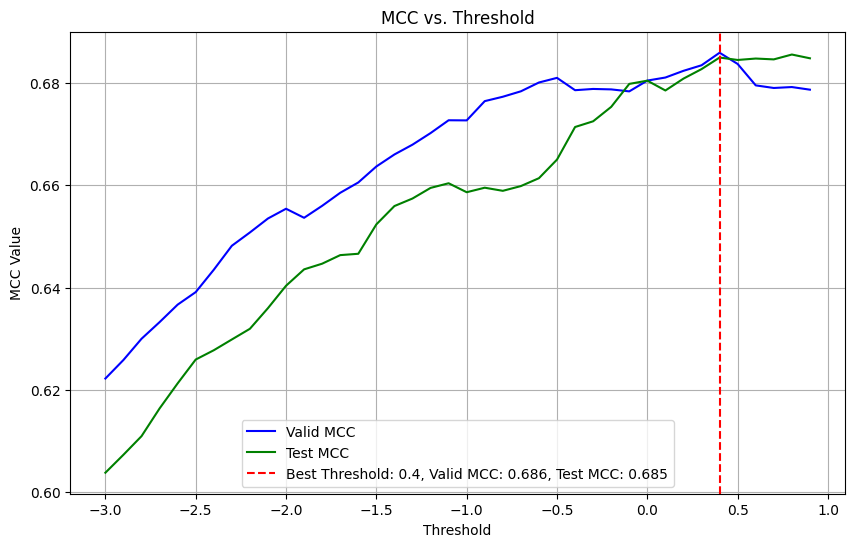

{'best_threshold': 0.4, 'valid_mcc': 0.6859, 'sensitivity': 0.7002, 'specificity': 0.9838, 'accuracy': 0.9691, 'precision': 0.7024, 'mcc': 0.685}
Ensemble of 20 random models:


,mean,std,max
best_threshold,0.400,0.0,0.400
valid_mcc,0.686,0.0,0.686
sensitivity,0.700,0.0,0.700
specificity,0.984,0.0,0.984
accuracy,0.969,0.0,0.969
precision,0.702,0.0,0.702
mcc,0.685,0.0,0.685


In [3]:
summarize_prefix(['v025'], n=20, plot=True, start=-3, end=1, step=0.1, seed_start=0, seed_end=40)

[('v018_0_0.6503_valid.csv', 'v018_0_0.6503_test.csv'), ('v018_1_0.6702_valid.csv', 'v018_1_0.6702_test.csv'), ('v018_2_0.6563_valid.csv', 'v018_2_0.6563_test.csv'), ('v018_3_0.6536_valid.csv', 'v018_3_0.6536_test.csv'), ('v018_4_0.6618_valid.csv', 'v018_4_0.6618_test.csv'), ('v018_5_0.6569_valid.csv', 'v018_5_0.6569_test.csv'), ('v018_6_0.6623_valid.csv', 'v018_6_0.6623_test.csv'), ('v018_7_0.6606_valid.csv', 'v018_7_0.6606_test.csv'), ('v018_8_0.6611_valid.csv', 'v018_8_0.6611_test.csv'), ('v018_12_0.6569_valid.csv', 'v018_12_0.6569_test.csv'), ('v018_13_0.6630_valid.csv', 'v018_13_0.6630_test.csv'), ('v018_14_0.6658_valid.csv', 'v018_14_0.6658_test.csv'), ('v018_15_0.6705_valid.csv', 'v018_15_0.6705_test.csv'), ('v018_16_0.6566_valid.csv', 'v018_16_0.6566_test.csv'), ('v018_17_0.6662_valid.csv', 'v018_17_0.6662_test.csv')]
Ensemble of all 15 models:


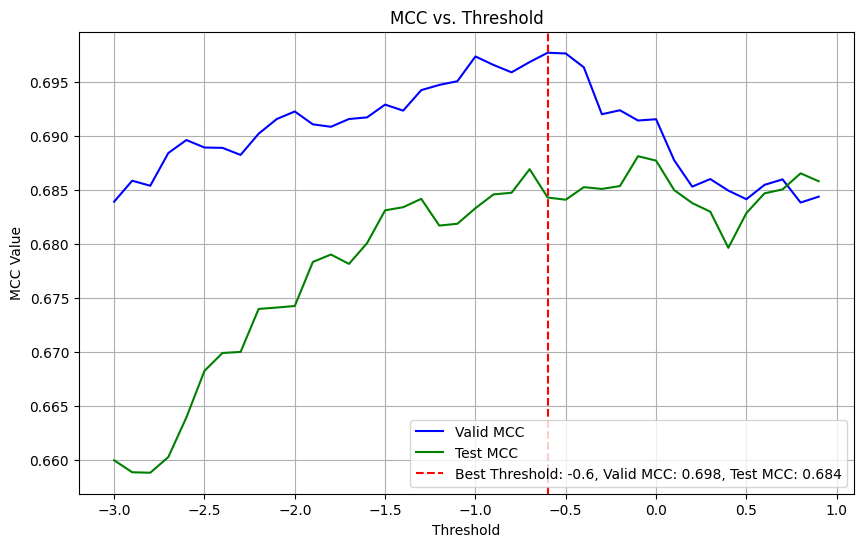

{'best_threshold': -0.6, 'valid_mcc': 0.6977, 'sensitivity': 0.6667, 'specificity': 0.9868, 'accuracy': 0.9703, 'precision': 0.7346, 'mcc': 0.6843}
Ensemble of 10 random models:


,mean,std,max
best_threshold,-0.690,0.595,0.500
valid_mcc,0.696,0.003,0.701
sensitivity,0.667,0.021,0.707
specificity,0.986,0.002,0.990
accuracy,0.970,0.001,0.971
precision,0.730,0.024,0.769
mcc,0.682,0.003,0.687


In [18]:
summarize_prefix(['v018'], n=10, plot=True, start=-3, end=1, step=0.1, seed_start=0, seed_end=40)

[('v015_0_0.6415_valid.csv', 'v015_0_0.6415_test.csv'), ('v015_1_0.6421_valid.csv', 'v015_1_0.6421_test.csv'), ('v015_2_0.6442_valid.csv', 'v015_2_0.6442_test.csv'), ('v015_3_0.6710_valid.csv', 'v015_3_0.6710_test.csv'), ('v015_4_0.6544_valid.csv', 'v015_4_0.6544_test.csv'), ('v015_5_0.6557_valid.csv', 'v015_5_0.6557_test.csv'), ('v015_6_0.6326_valid.csv', 'v015_6_0.6326_test.csv'), ('v015_7_0.6467_valid.csv', 'v015_7_0.6467_test.csv'), ('v015_8_0.6377_valid.csv', 'v015_8_0.6377_test.csv'), ('v015_9_0.6576_valid.csv', 'v015_9_0.6576_test.csv'), ('v015_10_0.6397_valid.csv', 'v015_10_0.6397_test.csv'), ('v015_11_0.6644_valid.csv', 'v015_11_0.6644_test.csv'), ('v015_12_0.6593_valid.csv', 'v015_12_0.6593_test.csv'), ('v015_13_0.6505_valid.csv', 'v015_13_0.6505_test.csv'), ('v015_14_0.6587_valid.csv', 'v015_14_0.6587_test.csv'), ('v015_15_0.6627_valid.csv', 'v015_15_0.6627_test.csv'), ('v015_16_0.6385_valid.csv', 'v015_16_0.6385_test.csv'), ('v015_17_0.6361_valid.csv', 'v015_17_0.6361_test.

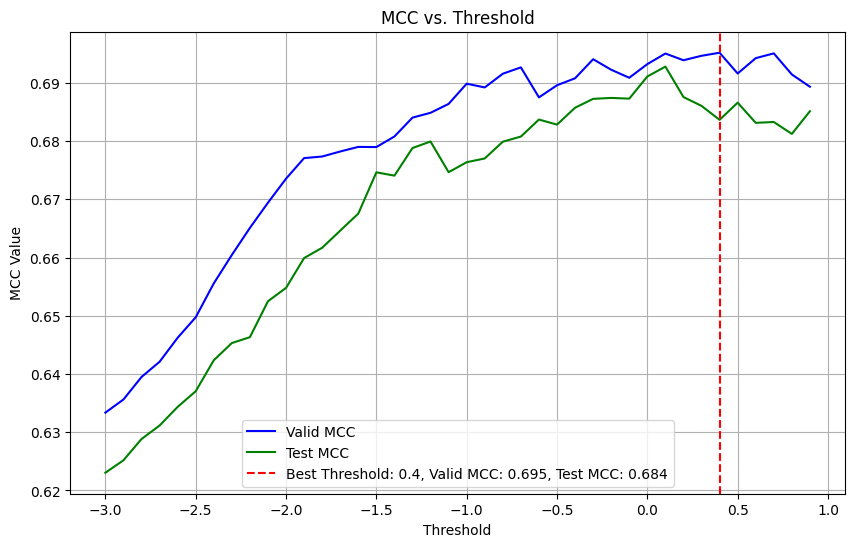

{'best_threshold': 0.4, 'valid_mcc': 0.6952, 'sensitivity': 0.6619, 'specificity': 0.9872, 'accuracy': 0.9703, 'precision': 0.7384, 'mcc': 0.6837}
Ensemble of 10 random models:


,mean,std,max
best_threshold,0.180,0.492,0.900
valid_mcc,0.694,0.003,0.699
sensitivity,0.668,0.019,0.697
specificity,0.987,0.002,0.989
accuracy,0.970,0.001,0.971
precision,0.733,0.020,0.754
mcc,0.684,0.002,0.687


In [19]:
summarize_prefix(['v015'], n=10, plot=True, start=-3, end=1, step=0.1, seed_start=0, seed_end=40)

[('v021_0_0.6796_valid.csv', 'v021_0_0.6796_test.csv'), ('v021_1_0.6802_valid.csv', 'v021_1_0.6802_test.csv'), ('v021_2_0.6841_valid.csv', 'v021_2_0.6841_test.csv'), ('v021_3_0.6904_valid.csv', 'v021_3_0.6904_test.csv'), ('v021_4_0.6831_valid.csv', 'v021_4_0.6831_test.csv'), ('v021_20_0.6757_valid.csv', 'v021_20_0.6757_test.csv'), ('v021_21_0.6805_valid.csv', 'v021_21_0.6805_test.csv'), ('v021_22_0.6831_valid.csv', 'v021_22_0.6831_test.csv'), ('v021_23_0.6799_valid.csv', 'v021_23_0.6799_test.csv'), ('v021_24_0.6701_valid.csv', 'v021_24_0.6701_test.csv'), ('v021_25_0.6755_valid.csv', 'v021_25_0.6755_test.csv'), ('v021_26_0.6924_valid.csv', 'v021_26_0.6924_test.csv'), ('v021_27_0.6859_valid.csv', 'v021_27_0.6859_test.csv'), ('v021_28_0.6705_valid.csv', 'v021_28_0.6705_test.csv'), ('v021_29_0.6741_valid.csv', 'v021_29_0.6741_test.csv'), ('v021_30_0.6739_valid.csv', 'v021_30_0.6739_test.csv'), ('v021_31_0.6728_valid.csv', 'v021_31_0.6728_test.csv'), ('v021_32_0.6834_valid.csv', 'v021_32_0.

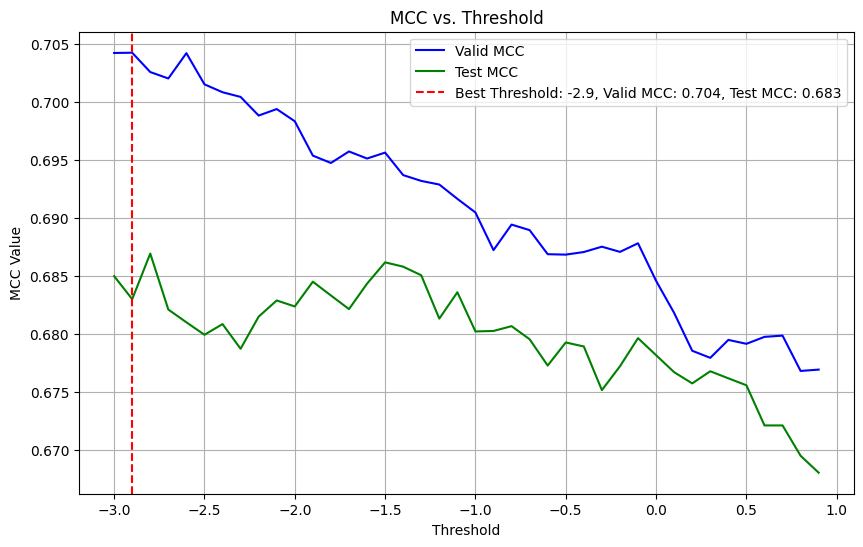

{'best_threshold': -2.9, 'valid_mcc': 0.7042, 'sensitivity': 0.6715, 'specificity': 0.9862, 'accuracy': 0.9699, 'precision': 0.7271, 'mcc': 0.683}
Ensemble of 10 random models:


,mean,std,max
best_threshold,-2.880,0.140,-2.600
valid_mcc,0.701,0.003,0.706
sensitivity,0.669,0.010,0.687
specificity,0.987,0.001,0.988
accuracy,0.970,0.000,0.971
precision,0.732,0.011,0.746
mcc,0.684,0.003,0.688


In [20]:
summarize_prefix(['v021'], n=10, plot=True, start=-3, end=1, step=0.1, seed_start=0, seed_end=40)

[('v038_0_0.6802_valid.csv', 'v038_0_0.6802_test.csv'), ('v038_1_0.6551_valid.csv', 'v038_1_0.6551_test.csv'), ('v038_2_0.6654_valid.csv', 'v038_2_0.6654_test.csv'), ('v038_3_0.6705_valid.csv', 'v038_3_0.6705_test.csv'), ('v038_4_0.6668_valid.csv', 'v038_4_0.6668_test.csv'), ('v038_5_0.6585_valid.csv', 'v038_5_0.6585_test.csv'), ('v038_6_0.6687_valid.csv', 'v038_6_0.6687_test.csv'), ('v038_7_0.6554_valid.csv', 'v038_7_0.6554_test.csv'), ('v038_8_0.6549_valid.csv', 'v038_8_0.6549_test.csv'), ('v038_9_0.6682_valid.csv', 'v038_9_0.6682_test.csv'), ('v038_10_0.6689_valid.csv', 'v038_10_0.6689_test.csv'), ('v038_11_0.6604_valid.csv', 'v038_11_0.6604_test.csv'), ('v038_12_0.6618_valid.csv', 'v038_12_0.6618_test.csv'), ('v038_13_0.6627_valid.csv', 'v038_13_0.6627_test.csv'), ('v038_14_0.6684_valid.csv', 'v038_14_0.6684_test.csv'), ('v038_15_0.6661_valid.csv', 'v038_15_0.6661_test.csv'), ('v038_16_0.6702_valid.csv', 'v038_16_0.6702_test.csv'), ('v038_17_0.6609_valid.csv', 'v038_17_0.6609_test.

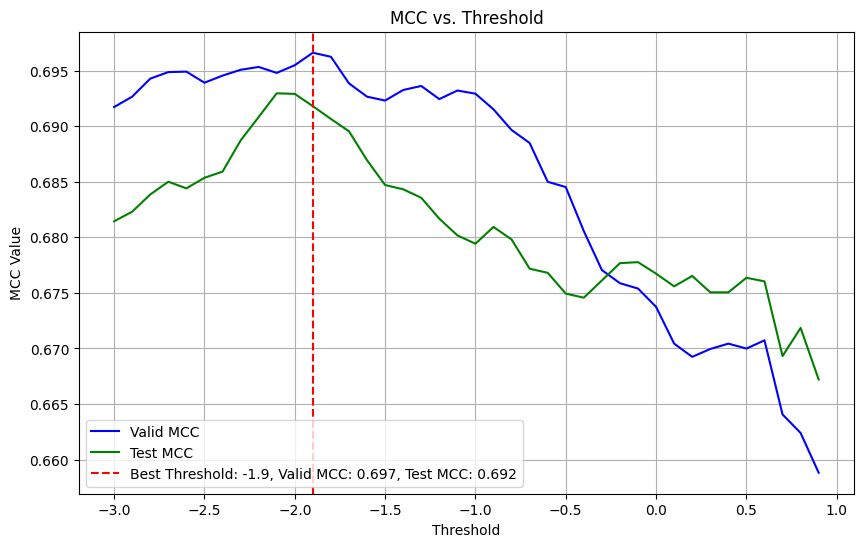

{'best_threshold': -1.9, 'valid_mcc': 0.6966, 'sensitivity': 0.6475, 'specificity': 0.9895, 'accuracy': 0.9717, 'precision': 0.7704, 'mcc': 0.6918}
Ensemble of 20 random models:


,mean,std,max
best_threshold,-1.900,0.0,-1.900
valid_mcc,0.697,0.0,0.697
sensitivity,0.648,0.0,0.648
specificity,0.989,0.0,0.989
accuracy,0.972,0.0,0.972
precision,0.770,0.0,0.770
mcc,0.692,0.0,0.692


In [4]:
summarize_prefix(['v038'], n=20, plot=True, start=-3, end=1, step=0.1, seed_start=0, seed_end=40)